# EEG Analysis: Arousal-Valence for Keystroke Dynamics

In [1]:
try:
    import sys
    import matplotlib as mpl

    SUBJECT = int(sys.argv[1])
    mpl.use('Agg')
    INTERACTIVE = False
except:
    %reset -f
    import matplotlib as mpl

    SUBJECT = 5
    INTERACTIVE = True

import os
import json
import pprint
import math
import itertools
import pandas
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib as mpl

from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
from collections import defaultdict

set_matplotlib_formats('png', 'pdf')

from mpl_toolkits.axes_grid1.axes_grid import AxesGrid
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

from sklearn import preprocessing
from scipy import signal
from scipy import stats
#from matplotlib2tikz import save as tikz_save, get_tikz_code

pgf_with_latex = {  # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",  # change this if using xetex or lautex
    "text.usetex": True,  # use LaTeX to write all text
    "font.family": "serif",
    "legend.fancybox": False,
    "legend.shadow": False,

    'xtick.major.size': 3,
    'xtick.major.width': 0.3,
    'ytick.major.size': 3,
    'ytick.major.width': 0.3,

    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",  # use utf8 fonts becasue your computer can handle it :)
    ]
}

mpl.rcParams.update(pgf_with_latex)


def save_matrix(filename, matrix, fmt='%5.3f'):
    np.savetxt(filename, matrix, fmt=fmt, delimiter=" & ", newline='\\\\\n')


/usr/lib/python3/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


## Configuration

In [2]:
PHI = (np.sqrt(5) - 1.0) / 2.0
LINEWIDTH = (52 / 9)  # width in inches


def latexify(fig_width=None, fig_height=None, ratio=None, legend_fontsize=10, fontsize=10, tick_fontsize=8,
             axes_fontsize=8):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples
    if fig_width is None:
        fig_width = LINEWIDTH

    if fig_height is None:
        if not ratio:
            ratio = PHI  # Aesthetic ratio
        fig_height = fig_width * ratio  # height in inches

    params = {'backend': 'ps',
              'text.latex.preamble': ['\\usepackage{gensymb}'],
              'axes.labelsize': axes_fontsize,  # fontsize for x and y labels (was 10)
              'axes.titlesize': axes_fontsize,
              'font.size': fontsize,
              'legend.fontsize': legend_fontsize,  # was 10
              'xtick.labelsize': tick_fontsize,
              'ytick.labelsize': tick_fontsize,
              'text.usetex': True,
              'figure.figsize': [fig_width, fig_height],
              'font.family': 'serif'
              }

    mpl.rcParams.update(params)

In [3]:
print('Subject: {}'.format(SUBJECT))
EPOCH_TYPE = "4s-1s"
RELAX_START_OFFSET = 0
RELAX_END_OFFSET = 0

SUBJECTS = ('02', '14', '04', '08', '01', '07', '06', '05', '16', '13', '03', '12')
SUBJECTS_SESSIONS = {
    '02': {'folder': 'session-2016.12.19-21.18-v02@eic', 'day': 0},
    '14': {'folder': 'session-2016.12.19-22.48-v14@eic', 'day': 0},
    '04': {'folder': 'session-2016.12.26-19.22-v04@eic', 'day': 7},
    '08': {'folder': 'session-2016.12.26-22.12-v08@eic', 'day': 7},
    '01': {'folder': 'session-2016.12.27-12.36-v01@eic', 'day': 8},
    '07': {'folder': 'session-2016.12.27-16.16-v07@eic', 'day': 8},
    '06': {'folder': 'session-2016.12.27-18.44-v06@eic', 'day': 8},
    '05': {'folder': 'session-2016.12.27-20.17-v05@eic', 'day': 8},
    '16': {'folder': 'session-2016.12.27-21.46-v16@eic', 'day': 8},
    '13': {'folder': 'session-2016.12.28-21.45-v13@eic', 'day': 9},
    '03': {'folder': 'session-2016.12.29-13.20-v03@eic', 'day': 10},
    '12': {'folder': 'session-2016.12.29-21.25-v12@eic', 'day': 10}
}

RAW_DIR_DATA = './../raw_data_data/'
RAW_DIR_TIMING = './../raw_data_timings/'
EEG_DIR = '../eeg/results/' + EPOCH_TYPE + '/'
EEG_FILENAME = 'v{0}.electrodes.data.csv'
AV_FILENAME = 'v{0}.av{1}.data.csv'
TIMESTAMPS_FILENAME = 'v{0}.timestamps.json'
GENERIC_FILENAME = 'v{0}'
AV_DIR = './data/'
RAW_EEG_DIR = 'eeg/'
RAW_DATA_FILENAME = 'data.json'
RAW_EEG_TIMING_FILENAME = 'timing.data'

selected_subject = SUBJECTS[SUBJECT]

# EEG
eeg_path = os.path.join(EEG_DIR, EEG_FILENAME.format(selected_subject))
eeg = np.genfromtxt(eeg_path, delimiter=',', skip_header=True, dtype=np.float64)

# EEG timing
eeg_timing_path = os.path.join(RAW_DIR_TIMING, SUBJECTS_SESSIONS[selected_subject]['folder'], RAW_EEG_DIR,
                               RAW_EEG_TIMING_FILENAME)
eeg_timing_file = open(eeg_timing_path)
eeg_timing = json.load(eeg_timing_file)
eeg_timing_file.close()

# Session data
raw_path = os.path.join(RAW_DIR_DATA, SUBJECTS_SESSIONS[selected_subject]['folder'], RAW_DATA_FILENAME)
raw_file = open(raw_path)
raw = json.load(raw_file)
raw_file.close()

# AV Data
av_path_non_standarized = os.path.join(AV_DIR, EPOCH_TYPE, AV_FILENAME.format(selected_subject, '_non_standarized'))
av_path_standarized = os.path.join(AV_DIR, EPOCH_TYPE, AV_FILENAME.format(selected_subject, '_standarized'))
av_path_standarized_scaled = os.path.join(AV_DIR, EPOCH_TYPE,
                                          AV_FILENAME.format(selected_subject, '_standarized_scaled'))
av_path_standarized_cropped_scaled = os.path.join(AV_DIR, EPOCH_TYPE,
                                                  AV_FILENAME.format(selected_subject, '_standarized_scaled_cropped'))


def show(f, filename):
    if INTERACTIVE:
        plt.show()
        print("show " + './data/kd/{}-{}'.format(SUBJECT + 1, filename))
    else:
        f.savefig('./data/kd/{}-{}'.format(SUBJECT + 1, filename), bbox_inches='tight')


def save_file(filename, contents):
    if INTERACTIVE:
        print(contents)
    else:
        file = open('./data/kd/{}-{}'.format(SUBJECT + 1, filename), 'wt')
        file.write(contents)
        file.close()


def get_sam(phase):
    for tp in ('images', 'audios', 'videos'):
        data = raw['acquisition']['stimuli_phases'][phase]['stimuli'].get(tp)
        if data:
            a, v = data['asssessment']['arousal'], data['asssessment']['valence']
            yield (tp, int(a), int(v))

Subject: 5


## Timestamps and session segments

### Offset adjustment

In [4]:
#
# Add a synchronization factor to avoid the desynchronization of the acquisition server
#
def desynchronization_offset(day):
    return day * 731.8 + 100


eeg_timing['start']['timestamp'] = ((int(eeg_timing['start']['timestamp']) * 1000) - desynchronization_offset(
    SUBJECTS_SESSIONS[selected_subject]['day'])) / 1000


### Session segments

In [5]:
# Search the event 'experiment' within the log
experiment_start = next((x for x in raw['log'] if x['event'] == 'experiment' and x['status'] == 's'), None)
experiment_end = next((x for x in raw['log'] if x['event'] == 'experiment' and x['status'] == 'e'), None)
# Search the event 'relaxation' within the log
relaxation_start = next((x for x in raw['log'] if x['event'] == 'relaxation' and x['status'] == 's'), None)
relaxation_end = next((x for x in raw['log'] if x['event'] == 'relaxation' and x['status'] == 'e'), None)
# Search the event 'relaxation' within the log
writing_start = next((x for x in raw['log'] if x['event'] == 'writing' and x['status'] == 's'), None)
writing_end = next((x for x in raw['log'] if x['event'] == 'writing' and x['status'] == 'e'), None)

# Get timestamps
ts_eeg_start = int(eeg_timing['start']['timestamp'] * 1000)
ts_experiment_start = experiment_start['timestamp']
ts_experiment_end = experiment_end['timestamp']
ts_relaxation_start = relaxation_start['timestamp'] + RELAX_START_OFFSET * 1000
ts_relaxation_end = relaxation_end['timestamp'] - 1 - RELAX_END_OFFSET * 1000
ts_writing_start = writing_start['timestamp']
ts_writing_end = writing_end['timestamp']

# Calculate upper and lower limits of the experimental session
delta_eeg_experiment_start = (ts_experiment_start - ts_eeg_start) / 1000
delta_eeg_experiment_end = (ts_experiment_end - ts_eeg_start) / 1000
# Calculate upper and lower limits of the relaxation phase in the experimental session
delta_eeg_relaxation_start = (ts_relaxation_start - ts_eeg_start) / 1000
delta_eeg_relaxation_end = (ts_relaxation_end - ts_eeg_start) / 1000
# Calculate upper and lower limits of the writing phase in the experimental session
delta_eeg_writing_start = (ts_writing_start - ts_eeg_start) / 1000
delta_eeg_writing_end = (ts_writing_end - ts_eeg_start) / 1000


def relativize_timestamp(ts):
    return (ts - ts_eeg_start) / 1000


timestamps = {}
_active = None

for log in raw['log']:

    # Debug
    # print(log['event'], log['status'], log['timestamp'], relativize_timestamp(log['timestamp']))

    if log['event'] == 'phase' and log['status'] == 's':
        _active = int(log['event_id'])
        timestamps[_active] = {}
        timestamps[_active]['start'] = relativize_timestamp(log['timestamp'])
        continue

    elif log['event'] == 'phase' and log['status'] == 'e':
        timestamps[_active]['end'] = relativize_timestamp(log['timestamp'])
        _active = None

    elif not _active:
        continue

    if not log['event'] in {'image', 'images', 'videos', 'audios', 'writing'}:
        continue

    elif not log['event'] in timestamps[_active]:
        timestamps[_active][log['event']] = []

        # Debug
    # print(log['timestamp'], relativize_timestamp(log['timestamp']))

    log_aux = log.copy()
    log_aux['timestamp'] = relativize_timestamp(log['timestamp'])
    timestamps[_active][log['event']].append(log_aux)

## Signal smoothing

The EEG signal is smoothed applying a convolution with a gaussian kernel. The number of points of the gaussian curve is four times the standard deviation value to one side, i.e., the standard deviation times four times two.

In [6]:
# win = signal.gaussian(96, std=8)
# win = signal.gaussian(64, std=8)
win = signal.gaussian(128, std=128)

eeg_smoothed = np.copy(eeg)
eeg_smoothed[:, 3] = signal.convolve(eeg_smoothed[:, 3], win, mode='same') / sum(win)
eeg_smoothed[:, 4] = signal.convolve(eeg_smoothed[:, 4], win, mode='same') / sum(win)
eeg_smoothed[:, 5] = signal.convolve(eeg_smoothed[:, 5], win, mode='same') / sum(win)
eeg_smoothed[:, 6] = signal.convolve(eeg_smoothed[:, 6], win, mode='same') / sum(win)
eeg_smoothed[:, 7] = signal.convolve(eeg_smoothed[:, 7], win, mode='same') / sum(win)
eeg_smoothed[:, 8] = signal.convolve(eeg_smoothed[:, 8], win, mode='same') / sum(win)
eeg_smoothed[:, 9] = signal.convolve(eeg_smoothed[:, 9], win, mode='same') / sum(win)
eeg_smoothed[:, 10] = signal.convolve(eeg_smoothed[:, 10], win, mode='same') / sum(win)


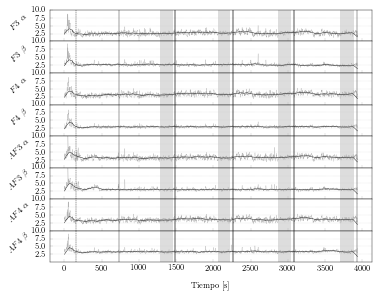

show ./data/kd/6-eeg.pdf


In [7]:
NUMBER_OF_GRAPHS = 8
latexify(ratio=PHI * 1.3)

# Subplots sharing both x/y axes
f, axes = plt.subplots(NUMBER_OF_GRAPHS, sharex=True, sharey=True)

for i, name in enumerate(('$F3\\ \\alpha$', '$F3\\ \\beta$',
                          '$F4\\ \\alpha$', '$F4\\ \\beta$',
                          '$AF3\\ \\alpha$', '$AF3\\ \\beta$',
                          '$AF4\\ \\alpha$', '$AF4\\ \\beta$')):
    #
    # SIGNALS
    #

    # Alpha & beta frequency bands
    axes[i].plot(eeg[:, 1], eeg[:, i + 3], color=str(0.7), linewidth=0.3)

    # Smoothed signal
    axes[i].plot(eeg_smoothed[:, 1], eeg_smoothed[:, i + 3], color='k', linewidth=0.4)

    #
    # LINES
    #

    # Relaxation separators
    axes[i].axvline(delta_eeg_relaxation_start, color='#111111', linestyle='--', linewidth=0.4)

    axes[i].tick_params(axis='both', direction='in', color='#aaaaaa')

    # keystroke
    for p in timestamps:
        axes[i].axvline(timestamps[p]['start'], color='#111111', linestyle='-', linewidth=0.4)
        axes[i].axvline(timestamps[p]['end'], color='#111111', linestyle='-', linewidth=0.4)
        if 'writing' in timestamps[p]:
            sta = timestamps[p]['writing'][0]['timestamp']
            end = timestamps[p]['writing'][1]['timestamp']
            axes[i].axvspan(sta, end, facecolor='#dddddd', linewidth=0)

    # Axes limits
    axes[i].set_ylim([0, 10])
    axes[i].yaxis.set_ticks([2.5, 5, 7.5, 10])
    axes[i].yaxis.grid(b=True, color='#cccccc',linestyle='dotted', linewidth=0.4)
    axes[i].set_ylabel(name, rotation=45, labelpad=10)
    for axis in ['top', 'bottom', 'left', 'right']:
        axes[i].spines[axis].set_linewidth(0.4)

axes[7].set_xlabel("Tiempo [s]", rotation=0, labelpad=10)

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

# draw or save it
plt.draw()
show(f, 'eeg.pdf')

## Arousal-Valence models

### Ramirez model

\begin{align}
\begin{cases} 
     Arousal = {\beta\over\alpha} = {{\beta_{F3} + \beta_{F4}}\over{\alpha_{F3} + \alpha_{F4}}} \\
     Valence = {\alpha_{F4} \over \beta_{F4}} - {\alpha_{F3} \over \beta_{F3}}
\end{cases}
\end{align}


### Yurci model

\begin{align}
\begin{cases} 
     Arousal = {\beta\over\alpha} = {{\beta_{AF4} + \beta_{AF3} + \beta_{F4} + \beta_{F3}}\over{\alpha_{AF4} + \alpha_{AF3} + \alpha_{F4} + \alpha_{F3}}} \\
     Valence = { \beta_{AF4} + \beta_{F4} \over \alpha_{AF4} + \alpha_{F4} } - { \beta_{AF3} + \beta_{F3} \over \alpha_{AF3} + \alpha_{F3} }
\end{cases}
\end{align}

In [8]:
def av_model_ramirez(row):
    """ Row must be sorted to have the following order of inputs related to the electrodes: 
        F3, F4, AF3, AF4; with the following order of frequency band values: Alpha, Beta. """

    alpha = row[::2]  # Odd columns (alpha values)
    beta = row[1::2]  # Even columns (beta values)

    arousal = (beta[0] + beta[1]) / (alpha[0] + alpha[1])
    valence = (alpha[1] / beta[1]) - (alpha[0] / beta[0])

    return [arousal, valence]


def av_model_yurci(row):
    """ Row must be sorted to have the following order of inputs related to the electrodes: 
        F3, F4, AF3, AF4; with the following order of frequency band values: Alpha, Beta. """

    alpha = row[::2]  # Odd columns (alpha values)
    beta = row[1::2]  # Even columns (beta values)

    arousal = beta.sum() / alpha.sum()
    valence = ((beta[3] + beta[1]) / (alpha[3] + alpha[1])) - ((beta[2] + beta[0]) / (alpha[2] + alpha[0]))
    # valence = ((alpha[3] + alpha[1]) / (beta[3] + beta[1])) - ((alpha[2] + alpha[0]) / (beta[2] + beta[0]))

    return [arousal, valence]

## Arousal-Valence calculation

In [9]:
# Calculate arousal and valence with alpha and beta values
arousal_valence = np.apply_along_axis(av_model_yurci, 1, eeg_smoothed[:, 3:])
arousal_valence = np.concatenate((eeg_smoothed[:, :3], arousal_valence), axis=1)

## Signal cropping

The signal is cropped to get relevant segments of values.

In [10]:
# Crop EEG to keep only the rows that belong to the session
av_session = np.copy(arousal_valence)
av_session = av_session[av_session[:, 1] >= delta_eeg_experiment_start]
av_session = av_session[av_session[:, 1] <= delta_eeg_experiment_end]

# Crop EEG to keep only the rows that belong to the relaxation phase 
av_relaxation = np.copy(arousal_valence)
av_relaxation = av_relaxation[av_relaxation[:, 1] >= delta_eeg_relaxation_start]
av_relaxation = av_relaxation[av_relaxation[:, 1] <= delta_eeg_relaxation_end]

# Crop EEG to keep only the rows that belong to the writing phase 
av_writing = np.copy(arousal_valence)
av_writing = av_writing[av_writing[:, 1] >= delta_eeg_writing_start]
av_writing = av_writing[av_writing[:, 1] <= delta_eeg_writing_end]

## Standarization of the Arousal-Valence values

This step includes not only standardization, but also the cutting of values respect to the calculaded standard deviation, i.e., the dataset is cropped to keep only the values that are within the range $[-3\sigma; 3\sigma]$.

In [11]:
# Standarize the data (Z-Score normalization)
scaler = preprocessing.StandardScaler().fit(av_relaxation[:, 3:])

# print('Mean: \t', scaler.mean_)
# print('Std: \t', scaler.scale_)

av_session_non_standarized = np.copy(av_session)

# Crop based on arousal axis
av_session = av_session[av_session[:, 3] >= (scaler.mean_[0] - 3 * scaler.scale_[0])]
av_session = av_session[av_session[:, 3] <= (scaler.mean_[0] + 3 * scaler.scale_[0])]
# Crop based on valence axis
av_session = av_session[av_session[:, 4] >= (scaler.mean_[1] - 3 * scaler.scale_[1])]
av_session = av_session[av_session[:, 4] <= (scaler.mean_[1] + 3 * scaler.scale_[1])]

av_session_standarized = np.concatenate(
    (av_session_non_standarized[:, :3], scaler.transform(av_session_non_standarized[:, 3:])), axis=1)
av_relaxation_standarized = np.concatenate((av_relaxation[:, :3], scaler.transform(av_relaxation[:, 3:])), axis=1)
av_session_standarized_cropped = np.concatenate((av_session[:, :3], scaler.transform(av_session[:, 3:])), axis=1)

av_session_standarized.shape
av_session_standarized_cropped.shape

(1918, 5)

In [12]:
# Scaling
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1, 9))

av_session_non_standarized_scaled = np.concatenate(
    (av_session_non_standarized[:, :3], min_max_scaler.fit_transform(av_session_non_standarized[:, 3:])), axis=1)
av_session_standarized_scaled = np.concatenate(
    (av_session_standarized[:, :3], min_max_scaler.fit_transform(av_session_standarized[:, 3:])), axis=1)
av_session_standarized_cropped_scaled = np.concatenate(
    (av_session_standarized_cropped[:, :3], min_max_scaler.fit_transform(av_session_standarized_cropped[:, 3:])),
    axis=1)

##############################

# '''
scaler = preprocessing.StandardScaler().fit(av_relaxation_standarized[:, 3:])
print('Mean: \t', scaler.mean_)
print('Std: \t', scaler.scale_)

av_relaxation_standarized_scaled = np.concatenate(
    (av_relaxation_standarized[:, :3], min_max_scaler.fit_transform(av_relaxation_standarized[:, 3:])), axis=1)
scaler = preprocessing.StandardScaler().fit(av_relaxation_standarized_scaled[:, 3:])
print('Mean: \t', scaler.mean_)
print('Std: \t', scaler.scale_)
# '''

Mean: 	 [ -8.28824189e-15  -1.75002463e-15]
Std: 	 [ 1.  1.]
Mean: 	 [ 5.20860104  3.74947425]
Std: 	 [ 2.52403022  1.94418188]


## Plotting of standardized Arousal-Valence values with t-test

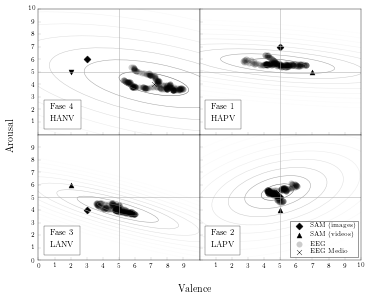

show ./data/kd/6-av_per_phase.pdf

\begin{table}
  \centering
  \begin{tabular}{rrccccp{0.5cm}cccc}
    \toprule
    && \multicolumn{4}{c}{Arousal} && \multicolumn{4}{c}{Valence}\\
    \cmidrule{3-6}\cmidrule(r){8-11}
    \verticalField{Estadístico}& Fase & 1 & 2 & 3 & 4 && 1 & 2 & 3 & 4 \\
    \cmidrule{3-6}\cmidrule(r){8-11}
& 1 & 15138 & 8016 & 0 & 0 && 15138 & 13651 & 13986 & 1534\\
& 2 & 8016 & 12482 & 0 & 601 && 13651 & 12482 & 11914 & 605\\
& 3 & 0 & 0 & 14964 & 12520 && 13986 & 11914 & 14964 & 900\\
& 4 & 0 & 601 & 12520 & 16562 && 1534 & 605 & 900 & 16562\\

    \midrule
   && \multicolumn{4}{c}{Arousal} && \multicolumn{4}{c}{Valence}\\
    \cmidrule{3-6}\cmidrule(r){8-11}
    \verticalField{$p$-value}& Fase & 1 & 2 & 3 & 4 && 1 & 2 & 3 & 4 \\
    \cmidrule{3-6}\cmidrule(r){8-11}
& 1 & 1.000 & 0.000 & 0.000 & 0.000 && 1.000 & 0.914 & 0.255 & 0.000\\
& 2 & 0.000 & 1.000 & 0.000 & 0.000 && 0.914 & 1.000 & 0.044 & 0.000\\
& 3 & 0.000 & 0.000 & 1.000 & 0.001 && 0.255 & 0.044 & 1.0

In [13]:
use = av_session_standarized_scaled
stimuli = 'writing'  # 'images' # ['images'|'videos_audios']

plt.close('all')
latexify(ratio=0.8, legend_fontsize=6)

COLS = 2
ROWS = 2
CONNECTION_STYLE = "arc3,rad=0.3"

PHASE_NAMES = (
    "Fase 1\\\\HAPV",
    "Fase 2\\\\LAPV",
    "Fase 3\\\\LANV",
    "Fase 4\\\\HANV"
)

f, axis = plt.subplots(ROWS, COLS, sharex='col', sharey='row')
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.00, hspace=0.00)
f.text(0.5, 0.03, 'Valence', ha='center')
f.text(0.05, 0.5, 'Arousal', va='center', rotation='vertical')

phase_positioning = {1: [0, 1], 2: [1, 1], 3: [1, 0], 4: [0, 0]}

axes = plt.gca()


def addLabel(ax, t):
    _at = AnchoredText(t, loc='lower left', prop={'size': 8}, borderpad=1)
    _at.patch.set_boxstyle("square", pad=0.3)
    _at.patch.set_linewidth(0.3)
    ax.add_artist(_at)
    return _at


writing_eeg = {}

sam_markers = {
    'audios': 'v',
    'videos': '^',
    'images': 'D'
}

sam_processed=[]
eeg_processed=[]

for phase_id in [1, 2, 3, 4]:
    for _stimuli in stimuli.split('_'):
        if not _stimuli in timestamps[phase_id]: continue

        av_phase = np.copy(use)
        av_phase = av_phase[av_phase[:, 1] >= timestamps[phase_id][_stimuli][0]['timestamp']]
        av_phase = av_phase[av_phase[:, 1] <= timestamps[phase_id][_stimuli][1]['timestamp']]

        label = '{\\noindent ' + PHASE_NAMES[phase_id - 1] + '}'
        pos = phase_positioning[phase_id]
        ax = axis[pos[0]][pos[1]]

        ax.axhline(5, color='#aaaaaa', linewidth=0.5)
        ax.axvline(5, color='#aaaaaa', linewidth=0.5)

        ax.xaxis.set_ticks(np.arange(pos[1], 10 + pos[1], 1))
        ax.yaxis.set_ticks(np.arange(1 - pos[0], 11 - pos[0], 1))
        ax.tick_params(axis='both', direction='in', color='#aaaaaa')
        ax.set_xlim([0, 10])
        ax.set_ylim([0, 10])

        for axis_pos in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis_pos].set_linewidth(0.4)

        writing_eeg[phase_id] = av_phase[:, 3:]


        # Correlation
        def eigsorted(cov):
            vals, vecs = np.linalg.eigh(cov)
            order = vals.argsort()[::-1]
            return vals[order], vecs[:, order]


        x = av_phase[:, 4]  # valence
        y = av_phase[:, 3]  # arousal

        cov = np.cov(x, y)
        vals, vecs = eigsorted(cov)
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        xymean=(np.mean(x), np.mean(y))
        
        for nstd in range(1, 10):
            w, h = 4 * nstd * np.sqrt(vals)
            ell = mpatches.Ellipse(xy=xymean,
                                   width=w, height=h,
                                   angle=theta, fill=False, color=str(1 - .6 ** nstd, ), linewidth=0.5)
            ax.add_patch(ell)

        eeg_processed.append((phase_id, np.array(xymean), cov))
            
        # SAM
        sam_aux={}
        for sam_type, sam_arousal, sam_valence in get_sam(str(phase_id)):
            sam_aux[sam_type=='images']=(sam_type, sam_arousal, sam_valence)
            ax.scatter(sam_valence, sam_arousal, color='k', label='SAM (%s)' % sam_type,
                       marker=sam_markers[sam_type], alpha=1, s=25, linewidth=0.4)

        sam_processed.append((phase_id, sam_aux))
            
        # Points
        ax.scatter(av_phase[:, 4], av_phase[:, 3], color='k', label='EEG', alpha=0.2, linewidth=0)

        # Mean
        ax.scatter(np.mean(x), np.mean(y), color='k', marker='x', label='EEG Medio', alpha=1, s=25, linewidth=0.4)

        ax.tick_params(axis='x', labelsize=6)
        ax.tick_params(axis='y', labelsize=6)
        addLabel(ax, label)

legend_loc = 'lower right' if SUBJECT not in {0, 1, 2, 3, 4, 6, 8, 9, 11} else 'upper left'

leg = plt.legend(loc=legend_loc)
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.5)

plt.draw()
show(f, 'av_per_phase.pdf')

theoretical_a = [
    [1, 0, 0, 1],
    [0, 1, 1, 0],
    [0, 1, 1, 0],
    [1, 0, 0, 1]
]

theoretical_v = [
    [1, 1, 0, 0],
    [1, 1, 0, 0],
    [0, 0, 1, 1],
    [0, 0, 1, 1]
]

pval_matrix = np.zeros((4, 4, 2))
statistic_matrix = np.zeros((4, 4, 2))
hypo_theoretical_matrix = np.array([theoretical_a, theoretical_v], dtype=bool).T

for phase_id_1 in [1, 2, 3, 4]:
    for phase_id_2 in [1, 2, 3, 4]:
        p1 = writing_eeg[phase_id_1]
        p2 = writing_eeg[phase_id_2]

        resulta = stats.mannwhitneyu(p1[:, 0], p2[:, 0])
        resultv = stats.mannwhitneyu(p1[:, 1], p2[:, 1])
        statistic_matrix[phase_id_1 - 1, phase_id_2 - 1] = np.around([resulta.statistic, resultv.statistic], decimals=3)
        pval_matrix[phase_id_1 - 1, phase_id_2 - 1] = np.around(2 * np.array([resulta.pvalue, resultv.pvalue]),
                                                                decimals=3)
        hypo_real_matrix = pval_matrix > 0.9


# print("real",hypo_real_matrix[:,:,1])
# print("pval",pval_matrix[:,:,1])
# print("eq",((hypo_real_matrix | hypo_theoretical_matrix) == hypo_theoretical_matrix)[:,:,1])

def format_table(vals, fmt):
    out = ''
    for i in range(4):
        out += r"& %d & %s && %s\\" % (i + 1,
                                       ' & '.join(fmt(a) for a in vals[i, :, 0]),
                                       ' & '.join(fmt(v) for v in vals[i, :, 1])) + '\n'
    return out


table = r"""
\begin{table}
  \centering
  \begin{tabular}{rrccccp{0.5cm}cccc}
    \toprule
    && \multicolumn{4}{c}{Arousal} && \multicolumn{4}{c}{Valence}\\
    \cmidrule{3-6}\cmidrule(r){8-11}
    \verticalField{Estadístico}& Fase & 1 & 2 & 3 & 4 && 1 & 2 & 3 & 4 \\
    \cmidrule{3-6}\cmidrule(r){8-11}
""" + format_table(statistic_matrix, lambda x: "%d" % x) + r"""
    \midrule
   && \multicolumn{4}{c}{Arousal} && \multicolumn{4}{c}{Valence}\\
    \cmidrule{3-6}\cmidrule(r){8-11}
    \verticalField{$p$-value}& Fase & 1 & 2 & 3 & 4 && 1 & 2 & 3 & 4 \\
    \cmidrule{3-6}\cmidrule(r){8-11}
""" + format_table(pval_matrix, lambda x: "%1.3f" % x) + r"""
    \midrule
    && \multicolumn{4}{c}{Arousal} && \multicolumn{4}{c}{Valence}\\
    \cmidrule{3-6}\cmidrule(r){8-11}
    \verticalField{$H_0$ aceptada}& Fase & 1 & 2 & 3 & 4 && 1 & 2 & 3 & 4 \\
    \cmidrule{3-6}\cmidrule(r){8-11}
""" + format_table(hypo_real_matrix, lambda x: "A" if x else "NA") + r"""
    \bottomrule
  \end{tabular}
  \caption{Resultados de cambios de fase para el participante número """ + str(SUBJECT + 1) + """.}
  \label{tab:eeg:""" + str(SUBJECT + 1) + """}
\end{table}"""

save_file("hypothesis.tex", table)

result_all = ((hypo_real_matrix | hypo_theoretical_matrix) == hypo_theoretical_matrix).all()
if not result_all:
    print("ERRORRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR!!!!!!!!!")

# save_matrix(os.path.join(AV_DIR, EPOCH_TYPE, 'v{}_pval_matrix.tex'.format(selected_subject)),pval_matrix)
# save_matrix(os.path.join(AV_DIR, EPOCH_TYPE, 'v{}_statistic_matrix.tex'.format(selected_subject)),statistic_matrix,fmt='%d')

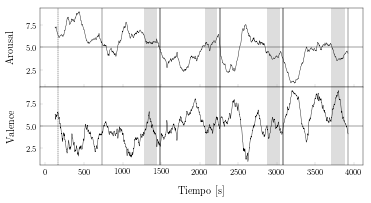

show ./data/kd/6-av.pdf


In [14]:
use = av_session_standarized_scaled

plt.close('all')
latexify(ratio=0.5)

# Subplots sharing both x/y axes
f, axes = plt.subplots(2, sharex=True, sharey=True)

# Arousal values
axes[0].plot(use[:, 1], use[:, 3], color='k', linewidth=0.4)
axes[0].set_ylabel('Arousal', rotation=90, labelpad=10, size=10)

# Valence values
axes[1].plot(use[:, 1], use[:, 4], color='k', linewidth=0.4)
axes[1].set_ylabel('Valence', rotation=90, labelpad=10, size=10)
axes[1].set_xlabel('Tiempo [s]', rotation=0, labelpad=10, size=10)

av_mean = [5, 5]

# Separators
for i in range(0, 2):

    # Horizontal
    axes[i].axhline(av_mean[i], color='#111111', linestyle='-', linewidth=0.4)

    # Relaxation separators
    axes[i].axvline(delta_eeg_relaxation_start, color='#111111', linestyle='--', linewidth=0.4)
    #     axes[i].axvline(delta_eeg_relaxation_end, color='k', alpha=0.2, linestyle='--')

    axes[i].tick_params(axis='both', direction='in', color='#aaaaaa')
    for axis_pos in ['top', 'bottom', 'left', 'right']:
        axes[i].spines[axis_pos].set_linewidth(0.4)

    # keystroke
    for p in timestamps:
        axes[i].axvline(timestamps[p]['start'], color='#111111', linestyle='-', linewidth=0.4)
        axes[i].axvline(timestamps[p]['end'], color='#111111', linestyle='-', linewidth=0.4)
        if 'writing' in timestamps[p]:
            sta = timestamps[p]['writing'][0]['timestamp']
            end = timestamps[p]['writing'][1]['timestamp']
            axes[i].axvspan(sta, end, facecolor='#dddddd', linewidth=0)

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.draw()
show(f, 'av.pdf')

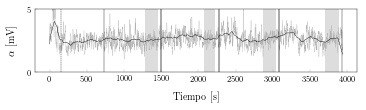

show ./data/kd/6-casoeegsimple.pdf


In [15]:
# Get current size
latexify(ratio=0.2)

# Subplots sharing both x/y axes
f, ax = plt.subplots()
electrode_index = 0

#
# SIGNALS
#

# Alpha & beta frequency bands
ax.plot(eeg[:, 1], eeg[:, electrode_index + 3], color=str(0.7), linewidth=0.3)

# Smoothed signal
ax.plot(eeg_smoothed[:, 1], eeg_smoothed[:, electrode_index + 3], color='k', linewidth=0.4)

#
# LINES
#

# Relaxation separators
ax.axvline(delta_eeg_relaxation_start, color='#111111', linestyle='--', linewidth=0.4)

ax.tick_params(axis='both', direction='in', color='#aaaaaa')
for axis_pos in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis_pos].set_linewidth(0.4)

# keystroke
for p in timestamps:
    ax.axvline(timestamps[p]['start'], color='#111111', linestyle='-', linewidth=0.4)
    ax.axvline(timestamps[p]['end'], color='#111111', linestyle='-', linewidth=0.4)
    if 'writing' in timestamps[p]:
        sta = timestamps[p]['writing'][0]['timestamp']
        end = timestamps[p]['writing'][1]['timestamp']
        ax.axvspan(sta, end, facecolor='#dddddd', linewidth=0)

# Axes limits
ax.set_ylim([0, 5])
ax.yaxis.set_ticks([0, 5])
ax.set_ylabel('$\\alpha$  [mV]', rotation=90, labelpad=10, size=10)

ax.set_xlabel("Tiempo [s]", rotation=0, labelpad=10, size=10)

# draw or save it
plt.draw()
show(f, 'casoeegsimple.pdf')

In [16]:
def get_ticks():
    counter = defaultdict(int)
    counter['speaking'] = -1
    counter['writing'] = -1
    counter['assessment'] = -1

    translate = {'name': 'Ingreso nombre',
                 'personal_data': 'Ingreso datos personales',
                 'relaxation': 'Relajaci\\\'on',
                 'game': 'Juego',
                 'assessment': 'SAM',
                 'writing': 'KD',
                 'speaking': 'Voz',
                 'audio': 'Audio',
                 'image': 'Imagen'}

    for log in raw['log']:
        if log.get('status') == 's':
            event = log['event']
            loc = relativize_timestamp(log['timestamp'])
            if event not in (
                    'experiment', 'video_recording', 'stimuli', 'videos', 'samples', 'images', 'audios', 'response'):
                counter[event] += 1
                if event == 'phase':
                    yield (loc, "{\\normalsize Fase %d}\\hspace{1.2cm}\\ ." % counter[event])
                else:
                    if event in ('image', 'audio', 'speaking', 'writing', 'assessment'):
                        val = "%s %d" % (translate.get(event, event), counter[event])
                    else:
                        val = translate.get(event, event)
                    yield (loc, val)


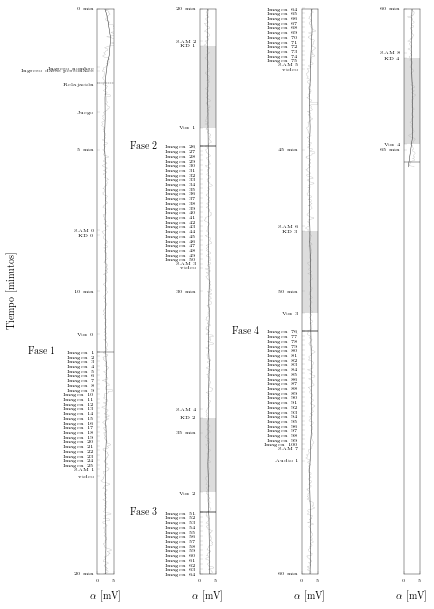

show ./data/kd/6-casoeeg.pdf


In [17]:
# Get current size
latexify(ratio=1.8,tick_fontsize=5)

TOTAL_DIVISIONS=4

fig_size = plt.rcParams["figure.figsize"]

# Set figure width and height
#plt.rcParams["figure.figsize"] = (15, 15)

# Subplots sharing both x/y axes
f, ax = plt.subplots(1,TOTAL_DIVISIONS)
electrode_index = 0

tick_except={15,25,40,55}

(xticks,xticklabels)=list(zip(*(list(get_ticks())+[(a,"%d min"%(a/60)) for a in range(0,3901,300) if a/60 not in tick_except])))
plt.setp(ax, yticks=xticks, yticklabels=xticklabels)

for i in range(TOTAL_DIVISIONS):
    time_min=i*1200
    time_max=time_min+1200

    #
    # SIGNALS
    #

    # Alpha & beta frequency bands
    ax[i].plot(eeg[:, electrode_index + 3],eeg[:, 1],  color=str(0.7), linewidth=0.3)

    # Smoothed signal
    ax[i].plot(eeg_smoothed[:, electrode_index + 3],eeg_smoothed[:, 1],  color='k', linewidth=0.4)

    #
    # LINES
    #

    # Relaxation separators
    ax[i].axhline(delta_eeg_relaxation_start, color='#111111', linestyle='--', linewidth=0.4)

    ax[i].tick_params(axis='both', direction='in', color='#aaaaaa')

    # keystroke
    for p in timestamps:
        ax[i].axhline(timestamps[p]['start'], color='#111111', linestyle='-', linewidth=0.4)
        ax[i].axhline(timestamps[p]['end'], color='#111111', linestyle='-', linewidth=0.4)
        if 'writing' in timestamps[p]:
            sta = timestamps[p]['writing'][0]['timestamp']
            end = timestamps[p]['writing'][1]['timestamp']
            ax[i].axhspan(sta, end, facecolor='#dddddd', linewidth=0)

    # Axes limits
    ax[i].set_xlim([0, 5])
    ax[i].xaxis.set_ticks([0, 5])
    ax[i].set_xlabel('$\\alpha$ [mV]', rotation=0, labelpad=10, size=10)


    ax[i].set_ylim([time_max, time_min])
    for axis_pos in ['top','bottom','left','right']:
        ax[i].spines[axis_pos].set_linewidth(0.4)

ax[0].set_ylabel("Tiempo [minutos]", rotation=90, size=10)
f.subplots_adjust(wspace=5.3)

# draw or save it
plt.draw()
show(f, 'casoeeg.pdf')

In [18]:
def get_images():
    for log in raw['log']:
        if log['event']=='image' and log['status']=='s':
            phase,image=log['event_id'].split('_')
            yield (int(image),int(phase))

print(list(get_images()))

[(8185, 1), (8030, 1), (5621, 1), (8370, 1), (8492, 1), (8190, 1), (8080, 1), (5833, 1), (1710, 1), (4660, 1), (8470, 1), (8200, 1), (8490, 1), (8186, 1), (8170, 1), (4668, 1), (4659, 1), (8499, 1), (7502, 1), (5825, 1), (4670, 1), (8180, 1), (8400, 1), (7405, 1), (8163, 1), (2340, 4), (1440, 4), (2040, 4), (5830, 4), (2050, 4), (2080, 4), (2070, 4), (1460, 4), (5210, 4), (1750, 4), (2154, 4), (2260, 4), (2550, 4), (7200, 4), (2057, 4), (1920, 4), (5829, 4), (2660, 4), (2091, 4), (1441, 4), (7492, 4), (2165, 4), (1463, 4), (2398, 4), (5982, 4), (8466, 3), (7476, 3), (9468, 3), (2309, 3), (5970, 3), (1945, 3), (6000, 3), (1505, 3), (2810, 3), (9171, 3), (9926, 3), (1280, 3), (1230, 3), (2795, 3), (9182, 3), (7037, 3), (2446, 3), (1270, 3), (2695, 3), (9584, 3), (9186, 3), (9080, 3), (9404, 3), (7520, 3), (2520, 3), (8475, 2), (1321, 2), (1120, 2), (1931, 2), (1726, 2), (6230, 2), (1050, 2), (1300, 2), (6550, 2), (1310, 2), (6350, 2), (1932, 2), (3000, 2), (3010, 2), (1930, 2), (6510, 2)

In [19]:
print(sam_processed) #phase_id, sam_type, sam_arousal, sam_valence

[(1, {True: ('images', 7, 5), False: ('videos', 5, 7)}), (2, {True: ('images', 5, 5), False: ('videos', 4, 5)}), (3, {True: ('images', 4, 3), False: ('videos', 6, 2)}), (4, {True: ('images', 6, 3), False: ('audios', 5, 2)})]


In [20]:
def sam_to_av(value_sam):
    (_,a,v)=value_sam
    return (str(a),str(v))

def eeg_to_av(value_eeg):
    return tuple('%5.2f' % a for a in value_eeg[::-1])

def eeg_errs(eeg_cov):
    return tuple('%5.2f' % a for a in eeg_cov[(1,0,0),(1,0,1)])

def subtract_sam(s1,s2):
    _,a1,v1=s1 #_ is True for images
    _,a2,v2=s2
    return (str(a2-a1),str(v2-v1))

def subtract_eeg(e1,e2):
    sub=e2-e1
    return tuple(
        ['%5.2f' % a for a in (sub[1],sub[0])]+
        ['\\multicolumn{3}{c}{$\\norm{\\Delta}=%4.2f$}' % np.linalg.norm(sub)])

def postprocess_av():
    prev=None
    prev_eeg=None
    aux=(r"""\begin{tabular}{cp{0.25cm}ccp{0.5cm}ccp{0.5cm}ccccc}
  \toprule
  && \multicolumn{2}{p{1cm}}{\centering SAM Img. } && \multicolumn{2}{p{1cm}}{\centering SAM Video } &&  \multicolumn{5}{c}{EEG } \\
  \cmidrule(l{1mm}r{1mm}){3-4}\cmidrule(l{1mm}r{1mm}){6-7}\cmidrule(l{1mm}r{1mm}){9-13}
  Fase && A & V &&  A & V &&  A & V &  $\sigma^2_\text{A}$ & $\sigma^2_\text{V}$ & $\sigma_\text{AV}$ \\
  \midrule"""+'\n')
    for (phase,eeg_mean,eeg_cov),(_,sam) in zip(eeg_processed,sam_processed):
        merged = itertools.chain(sam_to_av(sam[True]),[''],sam_to_av(sam[False]),[''],eeg_to_av(eeg_mean),eeg_errs(eeg_cov))
        if prev:
            aux+=('  $\\Delta$ && '+' & '.join(itertools.chain(subtract_sam(prev[False],sam[True]),[''],
                                                   subtract_sam(prev[False],sam[False]),[''],
                                                   subtract_eeg(prev_eeg,eeg_mean)))+'\\\\\n')
            aux+=('  \\hline\n')
        aux+=('  %d && '%phase+' & '.join(merged)+'\\\\\n')
        prev=sam
        prev_eeg=eeg_mean

    aux+=(r"""  \bottomrule
\end{tabular}"""+'\n')
    return aux

save_file("summary.tex", postprocess_av())


\begin{tabular}{cp{0.25cm}ccp{0.5cm}ccp{0.5cm}ccccc}
  \toprule
  && \multicolumn{2}{p{1cm}}{\centering SAM Img. } && \multicolumn{2}{p{1cm}}{\centering SAM Video } &&  \multicolumn{5}{c}{EEG } \\
  \cmidrule(l{1mm}r{1mm}){3-4}\cmidrule(l{1mm}r{1mm}){6-7}\cmidrule(l{1mm}r{1mm}){9-13}
  Fase && A & V &&  A & V &&  A & V &  $\sigma^2_\text{A}$ & $\sigma^2_\text{V}$ & $\sigma_\text{AV}$ \\
  \midrule
  1 && 7 & 5 &  & 5 & 7 &  &  5.65 &  4.84 &  0.04 &  0.78 & -0.08\\
  $\Delta$ && 0 & -2 &  & -1 & -2 &  & -0.22 &  0.00 & \multicolumn{3}{c}{$\norm{\Delta}=0.22$}\\
  \hline
  2 && 5 & 5 &  & 4 & 5 &  &  5.43 &  4.84 &  0.11 &  0.26 &  0.07\\
  $\Delta$ && 0 & -2 &  & 2 & -3 &  & -1.37 &  0.08 & \multicolumn{3}{c}{$\norm{\Delta}=1.37$}\\
  \hline
  3 && 4 & 3 &  & 6 & 2 &  &  4.06 &  4.92 &  0.07 &  0.40 & -0.14\\
  $\Delta$ && 0 & 1 &  & -1 & 0 &  & -0.01 &  2.24 & \multicolumn{3}{c}{$\norm{\Delta}=2.24$}\\
  \hline
  4 && 6 & 3 &  & 5 & 2 &  &  4.05 &  7.16 &  0.23 &  1.17 & -0.26\\
  \bo